# Plot audio voltage

This notebook plots the voltage of a badge based on the voltage stored in an audio samples file. Can be used for measuring badge battery usage and total run time. Here, we use it for comparing a badge with an old firmware, and a badge with the new firmware (2.0)

New badge (firmware 2.0) - F2:37:E3:BA:70:9D

old badge - CE:05:A0:D6:8C:80

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pandas as pd
import numpy as np
import pytz
import dateutil
#import seaborn as sns
#sns.set(style="whitegrid")
from ggplot import *
import gzip

%matplotlib inline

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(src_dir)

# import data analysis modules
import openbadge_analysis as ob

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# list of modules to autoload
%aimport openbadge_analysis

In [3]:
eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')

filename = '/home/orenled/temp/logs/4_log_audio.txt.gz'
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [4]:
# load data into a data frame
df = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp','voltage','num_samples'])
print(df.head())

       badge_address     timestamp  voltage  num_samples
0  CE:05:A0:D6:8C:80  1.483031e+09    3.121            2
1  F2:37:E3:BA:70:9D  1.483031e+09    3.234            2
2  CE:05:A0:D6:8C:80  1.483031e+09    3.121          114
3  CE:05:A0:D6:8C:80  1.483031e+09    3.121          114
4  CE:05:A0:D6:8C:80  1.483031e+09    3.121           19


In [5]:
#print(df_audio_voltage[df_audio_voltage['badge_address']=='D4:E4:47:A5:F0:B3'])
#df_audio_voltage=df_audio_voltage[df_audio_voltage['badge_address']=='D4:E4:47:A5:F0:B3']

# Sainty check

In [6]:
# min/max values
df_group_by_badge = df.reset_index().groupby('badge_address')
print("Max:\n",df_group_by_badge.max(),"\n")
print("Min:\n",df_group_by_badge.min())

Max:
                     index     timestamp  voltage  num_samples
badge_address                                                
CE:05:A0:D6:8C:80  138720  1.483319e+09    3.164          114
F2:37:E3:BA:70:9D  198185  1.483536e+09    3.234          114 

Min:
                    index     timestamp  voltage  num_samples
badge_address                                               
CE:05:A0:D6:8C:80      0  1.483031e+09    2.182            1
F2:37:E3:BA:70:9D      1  1.483031e+09    2.046            0


In [7]:
# Nans?
print(len(df))
print(df[np.isnan(df['voltage'])])
print(df[np.isnan(df['timestamp'])])
print(df[df['badge_address'].isnull()])

198186
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []


# show voltage graphs

In [8]:
# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index so I can convert the timezone
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize(utc)
df = df.tz_convert(eastern)

# make it a column again
df = df.reset_index() 
print(df['datetime'].dtype)

# set index
df.set_index(['badge_address','datetime'], inplace=True, drop=True)

# Sort
df.sort_index(inplace=True)
print(df.head())

datetime64[ns, US/Eastern]
                                                       timestamp  voltage  \
badge_address     datetime                                                  
CE:05:A0:D6:8C:80 2016-12-29 12:07:34.676000-05:00  1.483031e+09    3.121   
                  2016-12-29 12:07:34.676000-05:00  1.483031e+09    3.121   
                  2016-12-29 12:07:40.377000-05:00  1.483031e+09    3.121   
                  2016-12-29 12:07:46.077000-05:00  1.483031e+09    3.121   
                  2016-12-29 12:07:46.077000-05:00  1.483031e+09    3.121   

                                                    num_samples  
badge_address     datetime                                       
CE:05:A0:D6:8C:80 2016-12-29 12:07:34.676000-05:00            2  
                  2016-12-29 12:07:34.676000-05:00          114  
                  2016-12-29 12:07:40.377000-05:00          114  
                  2016-12-29 12:07:46.077000-05:00           19  
                  2016-12-29 12:07:46

In [9]:
# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#aggregation
# reample doesn't always like multi index
df_by_datetime = df.reset_index('badge_address', drop=False)


df_grouped = df_by_datetime.groupby('badge_address')
print("df_grouped\n",df_grouped)
print(df_grouped.size(),"\n\n")

df_resampled = df_grouped.resample('5S').agg({'voltage': np.mean, 'num_samples': np.max})
print("df_resampled:\n",df_resampled.head(),"\n\n")

df_flat = df_resampled.reset_index()
print("df_flat:\n",df_flat.head(),"\n\n")

df_grouped
badge_address
CE:05:A0:D6:8C:80     68862
F2:37:E3:BA:70:9D    129324
dtype: int64 


df_resampled:
                                              voltage  num_samples
badge_address     datetime                                       
CE:05:A0:D6:8C:80 2016-12-29 12:07:30-05:00    3.121        114.0
                  2016-12-29 12:07:35-05:00      NaN          NaN
                  2016-12-29 12:07:40-05:00    3.121        114.0
                  2016-12-29 12:07:45-05:00    3.121        114.0
                  2016-12-29 12:07:50-05:00    3.121        114.0 


df_flat:
        badge_address                  datetime  voltage  num_samples
0  CE:05:A0:D6:8C:80 2016-12-29 12:07:30-05:00    3.121        114.0
1  CE:05:A0:D6:8C:80 2016-12-29 12:07:35-05:00      NaN          NaN
2  CE:05:A0:D6:8C:80 2016-12-29 12:07:40-05:00    3.121        114.0
3  CE:05:A0:D6:8C:80 2016-12-29 12:07:45-05:00    3.121        114.0
4  CE:05:A0:D6:8C:80 2016-12-29 12:07:50-05:00    3.121        114.0

In [10]:
print(df_flat[:5])

       badge_address                  datetime  voltage  num_samples
0  CE:05:A0:D6:8C:80 2016-12-29 12:07:30-05:00    3.121        114.0
1  CE:05:A0:D6:8C:80 2016-12-29 12:07:35-05:00      NaN          NaN
2  CE:05:A0:D6:8C:80 2016-12-29 12:07:40-05:00    3.121        114.0
3  CE:05:A0:D6:8C:80 2016-12-29 12:07:45-05:00    3.121        114.0
4  CE:05:A0:D6:8C:80 2016-12-29 12:07:50-05:00    3.121        114.0


## Plot using ggplot

In [11]:
# for ggplot, you need to use dateutil timezones
tz_dateutil_est = dateutil.tz.gettz('US/Eastern')

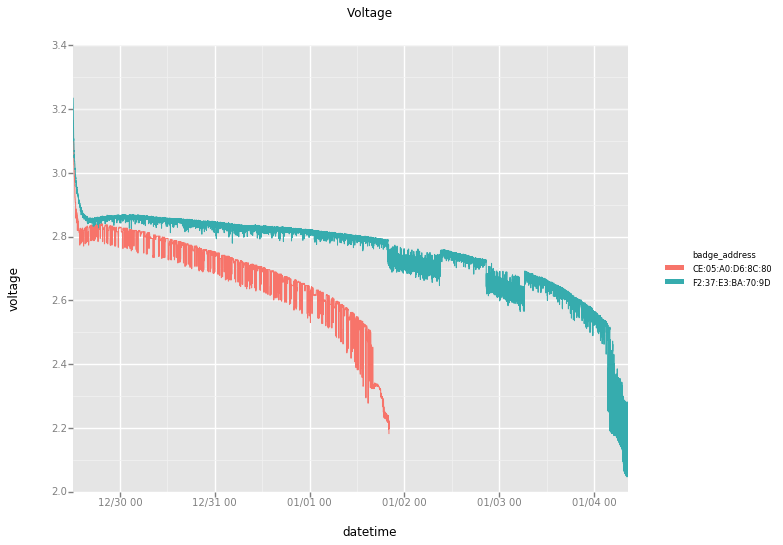

<ggplot: (8770100926933)>

In [12]:
ggplot(aes(x='datetime', y='voltage', color='badge_address'), data=df_flat) +\
    geom_line()+\
    scale_x_date(labels = date_format("%m/%d %H", tz = tz_dateutil_est)) +\
    ggtitle("Voltage")

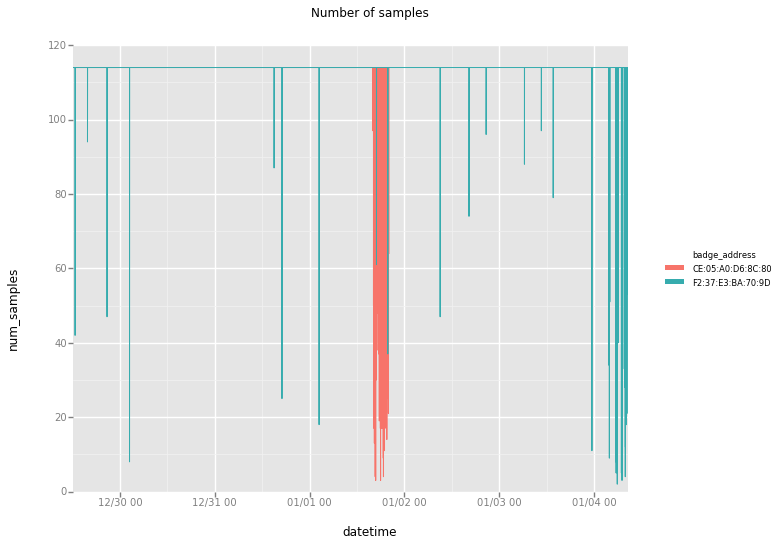

<ggplot: (8770055633705)>

In [13]:
ggplot(aes(x='datetime', y='num_samples', color='badge_address'), data=df_flat) +\
    geom_line() +\
    scale_x_date(labels = date_format("%m/%d %H", tz = tz_dateutil_est)) +\
    ggtitle("Number of samples")

## Realtive time (instead of absolute time)

In [14]:
first_data = df_flat.groupby('badge_address').first().rename(columns={'datetime':'first_datetime'})
first_data.reset_index(inplace=True)
del first_data['voltage']
del first_data['num_samples']
first_data

,badge_address,first_datetime
0,CE:05:A0:D6:8C:80,2016-12-29 12:07:30-05:00
1,F2:37:E3:BA:70:9D,2016-12-29 12:07:35-05:00


In [15]:
df_flat_realtive_time = pd.merge(df_flat, first_data, how='left',on='badge_address')
df_flat_realtive_time['relative'] = df_flat_realtive_time['datetime'] - df_flat_realtive_time['first_datetime']
df_flat_realtive_time['relative_days'] = df_flat_realtive_time['relative']/pd.Timedelta(days=1)

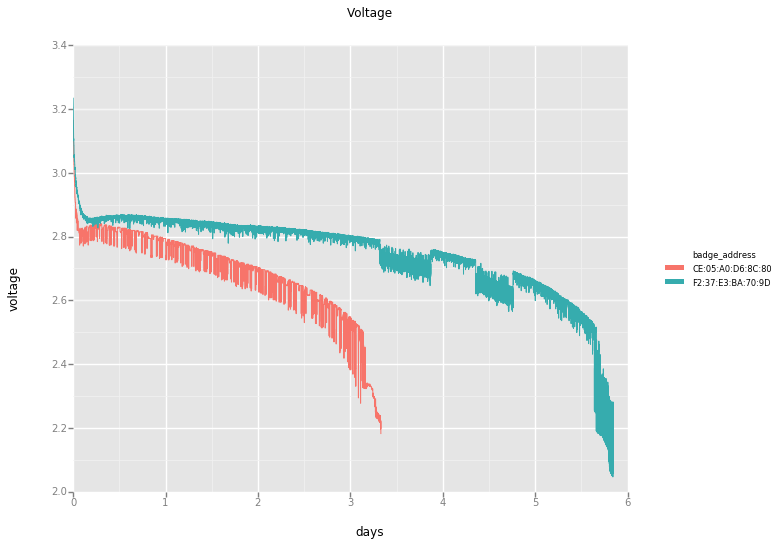

<ggplot: (8770057382085)>

In [16]:
ggplot(aes(x='relative_days', y='voltage', color='badge_address'), data=df_flat_realtive_time) +\
    geom_line() +\
    xlab("days") +\
    ggtitle("Voltage")

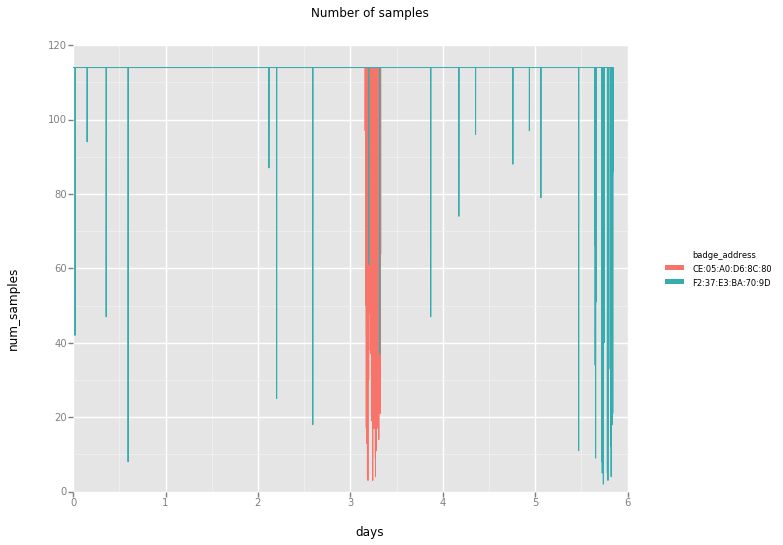

<ggplot: (8770056935157)>

In [17]:
ggplot(aes(x='relative_days', y='num_samples', color='badge_address'), data=df_flat_realtive_time) +\
    geom_line() +\
    xlab("days") +\
    ggtitle("Number of samples")